In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs

import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
mpl.rcParams["figure.dpi"] = 100
import seaborn as sns
plt.style.use('presentation.mplstyle')
import logging

# Get the logger for 'fontTools'
font_tools_logger = logging.getLogger('fontTools')

# Set the logging level to WARNING, which ignores DEBUG and INFO messages
font_tools_logger.setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\transport\SI"

In [3]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\graphs"
plates = [
    "441_20230807", "449_20230807", "310_20230830"
]
plate_id = plates[0]
path_tot = os.path.join(path_root,f"graph{plate_id}_video.pickle")
spatial_temporal_graph,folders = load(path_tot)

In [4]:
spatial_temporal_graph_sub = create_subgraph_by_attribute(spatial_temporal_graph,"post_hyperedge_activation",39)

In [6]:
exp = make_exp(spatial_temporal_graph_sub,folders)
weights = {(begin, end): data["37"]['water_flux_heaton'] if 'water_flux_heaton' in data["37"] else 0 for begin, end, data in
           spatial_temporal_graph_sub.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph_sub, weights, "water_flux_heaton_42")
weights = {(begin, end): data["37"]['width'] if 'water_flux_heaton' in data["37"] else 0 for begin, end, data in
           spatial_temporal_graph_sub.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph_sub, weights, "radius_42")


In [7]:
radii = [data['radius_42']/2 for begin,end,data in spatial_temporal_graph_sub.edges(data=True) if 'speed_heaton' in data["37"]]
carbon_flux= [abs(data['water_flux_heaton_42'])*C_factor_volume for begin,end,data in spatial_temporal_graph_sub.edges(data=True) if 'speed_heaton' in data["37"]]

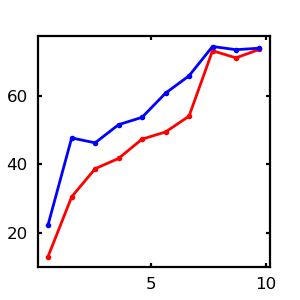

In [11]:

# Create a DataFrame for easier manipulation
df = pd.DataFrame({'carbon_flux': carbon_flux, 'radii': radii})
power = 2
df['radii_power'] = np.pi*df['radii']**power
num_bins = 10

# Create bins for carbon_flux
df['bin'] = pd.cut(df['carbon_flux'], bins=num_bins)

# Group by bin and calculate the 10th percentile for radii_squared in each bin
percentiles = df.groupby('bin')['radii_power'].quantile(0.10).reset_index()
medians = df.groupby('bin')['radii_power'].quantile(0.50).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(1.5, 1.5))
# ax.scatter(df['carbon_flux'], df['radii_power'], alpha=0.1)

# Plot the 10th percentile for each bin
# We need to calculate the center of each bin for plotting
percentiles['bin_center'] = percentiles['bin'].apply(lambda x: x.mid)
medians['bin_center'] = medians['bin'].apply(lambda x: x.mid)

ax.plot(percentiles['bin_center'], percentiles['radii_power'], color='red', marker='o')
# ax.plot(percentiles['bin_center'], percentiles['radii_power'], color='red', marker='o')
ax.plot(medians['bin_center'], medians['radii_power'], color='blue', marker='o')

ax.set_xlabel("carbon flux ($\mu m^3/s$)")
ax.set_ylabel("hyphal cross section ($\mu m^2$)")
plt.savefig(
    os.path.join(path_figure, "lipid_flux_radius.pdf"),
    transparent=True,
    bbox_inches="tight",
)
